author: Samuel Begg

date: 06/04/2024

Compute Fisher information for a periodically driven XY model, as discussed in Mishra, Bayat, Phys. Rev. Lett. 127, 080504 (2021)

1. Define simulation parameters

In [25]:
import methods
import numpy as np
import scipy.linalg as lin
from datetime import datetime
import copy
from joblib import Parallel, delayed

stem0 = '/Users/samuelbegg/'
stem = stem0  + 'Documents/Projects/Sensing/'

# System parameters for periodic boundary condition spin chain.
J = 1.0
gamma = 1.0
h1 = 0 # The periodic field is set to zero when considering the ground-state
sites = 6000
boundary_conditions = 'ABC' #'PBC' = periodic boundary conditions or 'ABC' = anti-periodic boundary conditions

# Notes: 
# The boundary conditions reflects the fermion parity of the ground-state.
# The Fourier transform definition is automatically adjusted based on number sites and boundary conditions, as in arXiv:1707.02400.

#Initial state
initial_state = 'ground_state' 
# 'ground_state': starts in the system ground-state. 
# 'flips': manually flips specific spins (with the rest down), see below. Default: single flip. Odd number of excitations (spin) = even parity (fermions) = PBC. 
# 'momentum': a k = 0 momentum state. Even parity = PBC.
# 'spin_up': all spins up, odd number excitations (spin) = even parity = PBC, even number excitations (spin) = odd parity (fermions) = ABC

# Sensing parameters
phasepoints = int(5) # points to sampling h0
h0mat = np.linspace(-1.5,1.5,phasepoints) + 0.00001 * np.ones(phasepoints) # range of points to sample
sub_system_range = np.arange(2,8,2) # np.arange(10,int(300)+1,10)  # range of subsystem sizes for evaluating Fisher information
sub_system_edge = 0 #index of the first site in the sub-system, 0 is the left boundary site.

# Computational 
tol = 10**(-10) # when evaluating the Fisher information we don't consider singular terms for which |1 - (w[rr]*w[ss])| < tol 
shift = 10**(-8) # finite division size for calculating derivative of reduced density matrix, i.e. drho/dh0 ~ (rho(h0) - rho(h0 + shift))/shift for the order2 version
derivative_estimator = 'order4' # 2nd order = 'order2' or 4th order 'order4' approximation for the derivative of reduced density matrix
num_cores = 16  # number of cores to parallelize with
save_results = 'save' # 'save' or 'bin' (don't save)

print(h0mat)

[-1.49999e+00 -7.49990e-01  1.00000e-05  7.50010e-01  1.50001e+00]


2. Calculate Fisher information for ground state

In [26]:
Fishermat = np.zeros([np.size(sub_system_range),np.size(h0mat)])

#Calculate fisher information for different subsystem sizes and h0 values
output = Parallel(n_jobs=num_cores)(delayed(methods.Fisher_Groundstate)(J, gamma, h0mat[uu], h1, sites, sub_system_range, sub_system_edge, tol, shift, derivative_estimator, boundary_conditions) for uu in range(0,np.size(h0mat)))

Fisher_mat = []

particle_numberL = []

singularities = []

for kk in range(0,phasepoints):
    
    data = output[kk]

    Fisher_mat = Fisher_mat + [data[0]]

    particle_numberL = particle_numberL + [data[1]]

    singularities = singularities + [data[2]]

Fishermat= np.asarray(Fisher_mat)

particle_number = np.asarray(particle_numberL)

singularities= np.asarray(singularities)


h0h0  h01.500011e-05

h0  -1.49999
0.75001h0
 -0.74999
1:53:59.702279 Time to calculate the initial correlation matrices
0:00:00.000265 Time to evaluate Gamma matrix for single h0
1:56:23.438517 Time to calculate the initial correlation matrices
0:00:00.000253 Time to evaluate Gamma matrix for single h0
1:57:49.320041 Time to calculate the initial correlation matrices
0:00:00.000263 Time to evaluate Gamma matrix for single h0
1:59:05.596101 Time to calculate the initial correlation matrices
0:00:00.000246 Time to evaluate Gamma matrix for single h0
2:00:07.709176 Time to calculate the initial correlation matrices
0:00:00.000244 Time to evaluate Gamma matrix for single h0
1:54:34.042907 Time to calculate the initial correlation matrices
0:00:00.000271 Time to evaluate Gamma matrix for single h0
1:56:58.952129 Time to calculate the initial correlation matrices
0:00:00.000258 Time to evaluate Gamma matrix for single h0
1:58:19.632287 Time to calculate the initial correlation matrices
0:00

3. Calculate ground state Fisher information for different gamma values

In [27]:
#Want to see scaling for some different gamma values too
gmat = [0.1,0.5,1]
h0_fix = 0.999995
output = Parallel(n_jobs=num_cores)(delayed(methods.Fisher_Groundstate)(J, gmat[gg], h0_fix , h1, sites, sub_system_range, sub_system_edge, tol, shift, derivative_estimator, boundary_conditions) for gg in range(0,np.size(gmat)))

Fisher_mat = []

particle_numberG = []

for kk in range(0,np.size(gmat)):
    
    data = output[kk]

    Fisher_mat = Fisher_mat + [data[0]]

    particle_numberG = particle_numberG + [data[1]]

FishermatGamma= np.asarray(Fisher_mat)

particle_numberG = np.asarray(particle_numberG)


h0 0.999995
h0 h00.999995 0.999995

1:53:35.259855 Time to calculate the initial correlation matrices
0:00:00.000261 Time to evaluate Gamma matrix for single h0
1:54:16.695045 Time to calculate the initial correlation matrices
0:00:00.000244 Time to evaluate Gamma matrix for single h0
1:54:27.854172 Time to calculate the initial correlation matrices
0:00:00.000239 Time to evaluate Gamma matrix for single h0


KeyboardInterrupt: 

Plot Fisher information for groundstates

(1.4711515351684419-3.5223993159251146e-22j)
(1.513926938458695-2.1834628196709353e-18j)
(1.5211971845496082-3.699197390120359e-18j)


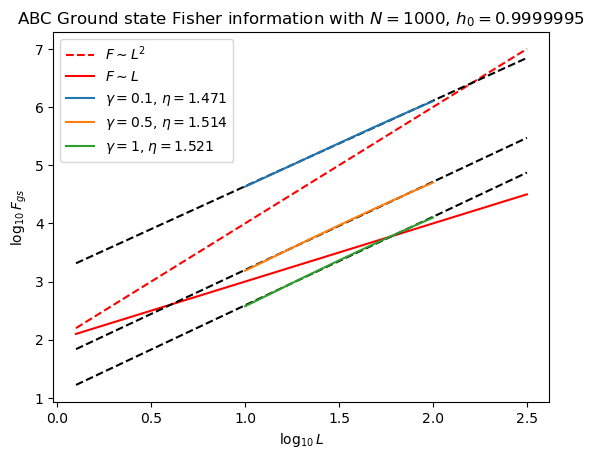

In [ ]:
if save_results == 'save':
    
    np.save('ResultsGS/gmat.npy',gmat)
    np.save('ResultsGS/Fisher_mat_Gamma_N' + str(sites) +'.npy',FishermatGamma)
    np.save('ResultsGS/Fisher_mat_N' + str(sites) +'.npy',Fishermat)
    np.save('ResultsGS/h0mat_N' + str(sites) +'.npy',h0mat)
    np.save('ResultsGS/subsystem_N' + str(sites) +'.npy',sub_system_range)

import matplotlib.pyplot as plt
plot_system_size_scaling = 'yes'

if plot_system_size_scaling == 'yes':



    # for ss in range(1,np.size(sub_system_range),2):

    #     plt.plot(h0mat,Fishermat[:,ss],'--o',label = 'L=' + str(sub_system_range[ss]))

    # plt.ylabel(r'$F_{gs}$')
    # plt.xlabel(r'$h_0$')
    # plt.title('Ground state Fisher information with $N = $' + str(sites) + ', $\gamma=$' + str(gamma))
    # plt.legend()
    # plt.show()

    # x = np.linspace(0.25,1.5,1000)
    # plt.plot(x,2*x-1,'--r',label = r'$F \sim L^{2}$')
    # plt.plot(x,x-1,'-r',label = r'$F \sim L$')
    # plt.plot(np.log10(sub_system_range),np.log10(Fishermat[int(np.size(h0mat)/2),:]),label = r'$h_0=$' + str(np.round(h0mat[int(np.size(h0mat)/2)],3)))
    # #plt.plot(np.log10(sub_system_range),np.log10(Fishermat[35,:]),label = r'$h_0=$' + str(np.round(h0mat[35],3)))
    # plt.plot(np.log10(sub_system_range),np.log10(Fishermat[7,:]),label = r'$h_0=$' + str(np.round(h0mat[0],3)))
    # plt.xlabel(r'$L$')
    # plt.ylabel(r'$F_{gs}$')
    # plt.title('Ground state Fisher information with $N = $' + str(sites) + ', $\gamma=$' + str(gamma))
    # plt.legend()
    # plt.show()

    x = np.linspace(0.1,2.5,1000)
    plt.plot(x,2*x+2,'--r',label = r'$F \sim L^{2}$')
    plt.plot(x,x+2,'-r',label = r'$F \sim L$')



    ranges = np.arange(0,np.size(sub_system_range))

    a0_0, a1 = np.polyfit(np.log10(sub_system_range[ranges]),np.log10(FishermatGamma[0,ranges]),1)
    plt.plot(x,a0_0*x+a1,'--k')

    print(a0_0)
    a0_1, a1 = np.polyfit(np.log10(sub_system_range[ranges]),np.log10(FishermatGamma[1,ranges]),1)
    plt.plot(x,a0_1*x+a1,'--k')
    print(a0_1)
    a0_2, a1 = np.polyfit(np.log10(sub_system_range[ranges]),np.log10(FishermatGamma[2,ranges]),1)
    plt.plot(x,a0_2*x+a1,'--k')
    print(a0_2)


    plt.plot(np.log10(sub_system_range),np.log10(FishermatGamma[0,:]),label = r'$\gamma=$' + str(np.round(gmat[0],3))+ r', $\eta = $' + str(np.round(np.real(a0_0),3)))
    plt.plot(np.log10(sub_system_range),np.log10(FishermatGamma[1,:]),label = r'$\gamma=$' + str(np.round(gmat[1],3))+ r', $\eta = $' + str(np.round(np.real(a0_1),3)))
    plt.plot(np.log10(sub_system_range),np.log10(FishermatGamma[2,:]),label = r'$\gamma=$' + str(np.round(gmat[2],3))+ r', $\eta = $' + str(np.round(np.real(a0_2),3)))
    plt.title(boundary_conditions + ' Ground state Fisher information with $N = $' + str(sites) + ', $h_0=$' + str(h0_fix))
    plt.xlabel(r'$\log_{10} L$')
    plt.ylabel(r'$\log_{10} F_{gs}$')
    plt.legend()
    plt.show()


(5, 3)


<>:29: SyntaxWarning: invalid escape sequence '\g'
<>:51: SyntaxWarning: invalid escape sequence '\g'
<>:29: SyntaxWarning: invalid escape sequence '\g'
<>:51: SyntaxWarning: invalid escape sequence '\g'
/var/folders/pb/7d4xww6j3131d4cdp0p3n2t40000gn/T/ipykernel_93099/2639302043.py:29: SyntaxWarning: invalid escape sequence '\g'
  plt.title('Ground state Fisher information with ' + '$\gamma=$' + str(gamma) + ', $N = $' + str(sites))
/var/folders/pb/7d4xww6j3131d4cdp0p3n2t40000gn/T/ipykernel_93099/2639302043.py:51: SyntaxWarning: invalid escape sequence '\g'
  plt.title('Ground state Magnetization with $N = $' + str(sites) + ', $\gamma=$' + str(gamma))


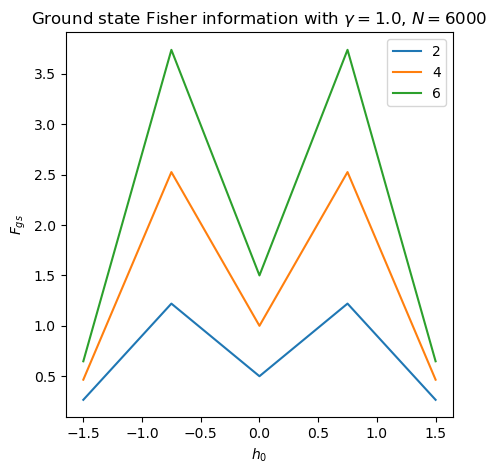

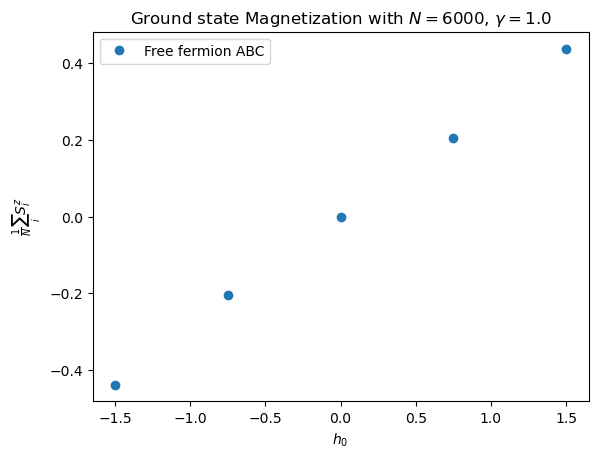

In [28]:
import matplotlib.pyplot as plt
#Comparison vs ED
ED_plot = 'no'



#Fisher vs h
fig1, ax = plt.subplots(1,1,figsize = (5,5))

for ss in range(0,len(sub_system_range)):

    plt.plot(h0mat, Fishermat[:,ss],'-',label = str(sub_system_range[ss]))

print(np.shape(Fisher_mat))
ss = 3

#np.save('/Users/samuelbegg/Documents/Sensing/ed_results/tempF_ABC.npy',Fishermat[:,ss])
#F_abc = np.load('/Users/samuelbegg/Documents/Sensing/ed_results/tempF_ABC.npy')
#plt.plot(h0mat,F_abc,'o',label = "ABC")

if ED_plot == 'yes':
    
    ED_fisher = np.load('/Users/samuelbegg/Documents/Sensing/ed_results/Fisher.npy')
    hzmat = np.load('/Users/samuelbegg/Documents/Sensing/ed_results/hzmat.npy')
    plt.plot(hzmat,ED_fisher,'x',label='ED')
    
plt.ylabel(r'$F_{gs}$')
plt.xlabel(r'$h_0$')
plt.title('Ground state Fisher information with ' + '$\gamma=$' + str(gamma) + ', $N = $' + str(sites))
plt.legend()

#plt.ylim(0,1000)
plt.show()

#Sz vs h
if ED_plot == 'yes':
    ED_spin = np.load('/Users/samuelbegg/Documents/Sensing/ed_results/mag.npy')
    hzmat = np.load('/Users/samuelbegg/Documents/Sensing/ed_results/hzmat.npy')
    plt.plot(hzmat,ED_spin ,'x',markersize = 8,label='ED')
    

#np.save('/Users/samuelbegg/Documents/Sensing/ed_results/tempF_ABC.npy',Fishermat[:,ss])
#p_abc = np.load('/Users/samuelbegg/Documents/Sensing/ed_results/tempP_ABC.npy')

#plt.plot(h0mat,p_abc-0.5,'o', label = 'Free fermion ' + "ABC")
plt.plot(h0mat,particle_number-0.5,'o', label = 'Free fermion ' + boundary_conditions)


plt.ylabel(r'$\frac{1}{N}\sum_i S^z_i$')
plt.xlabel(r'$h_0$')
plt.title('Ground state Magnetization with $N = $' + str(sites) + ', $\gamma=$' + str(gamma))
plt.legend()
plt.show()

#Discrepancy Sz vs Exact Diagonalization
# plt.plot(h0mat,particle_number-0.5 - ED_spin,label = 'Free fermion ' + boundary_conditions)
# plt.ylabel(r'Discrepency Sz')
# plt.xlabel(r'$h_0$')
# plt.title('$N = $' + str(sites) + ', $\gamma=$' + str(gamma))
# plt.legend()
# plt.ylim(-0.01,0.01)
# plt.show()

#Discrepancy Fisher vs Exact Diagonalization
# plt.plot(h0mat,Fishermat[:,ss] - ED_fisher,label = 'Free fermion ' + boundary_conditions)
# plt.ylabel(r'Discrepency Fisher')
# plt.xlabel(r'$h_0$')
# plt.title('$N = $' + str(sites) + ', $\gamma=$' + str(gamma))
# plt.legend()
# plt.ylim(-0.01,0.01)
# plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(151, 10)


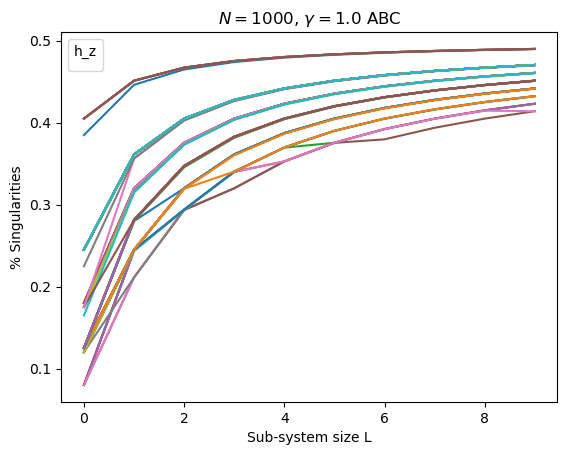

In [ ]:
print(np.shape(singularities))

for kk in range(0, int(phasepoints/2) +1):
 
    plt.plot(singularities[kk, :])

plt.xlabel("Sub-system size L")
plt.ylabel("% Singularities")
plt.legend(title = "h_z")
plt.title(r'$N = $' + str(sites) + r', $\gamma=$' + str(gamma) + ' '+ boundary_conditions)
plt.show()


# dag_pbc = np.load("Dag_pbc.npy")
# dag_abc = np.load("Dag_abc.npy")

# obs_pbc = np.load("obs_pbc.npy")
# obs_abc = np.load("obs_abc.npy")


# print("diff", np.round(np.abs(dag_pbc-dag_abc),5))

#print("diff", np.round(np.abs(obs_pbc - obs_abc),5))
#Difference is in 